In [1]:
%load_ext autoreload
%autoreload 2

In [72]:
import torch as ch
import numpy as np
import torch.nn as nn
import os
import argparse
import seaborn as sns
import copy
from tqdm import tqdm

from mib.models.utils import get_model
from sklearn.datasets import make_spd_matrix
from mib.utils import get_models_path
from mib.dataset.utils import get_dataset
from mib.train import get_loader, train_model, evaluate_model
from mib.attacks.theory_new import compute_hessian, fast_ihvp

from torch.utils.data import TensorDataset, DataLoader

from torch_influence.modules import HVPModule, LiSSAInfluenceModule, CGInfluenceModule, ShanksSablonniereModule
from torch_influence.base import BaseObjective
from livelossplot import PlotLosses

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
# Font-type and figure DPI
mpl.rcParams["figure.dpi"] = 500
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
plt.rcParams["font.family"] = "Times New Roman"

# Increase font
plt.rcParams.update({"font.size": 12})
# Increase font of axes and their labels
plt.rcParams.update({"axes.labelsize": 14})
plt.rcParams.update({"xtick.labelsize": 14})
plt.rcParams.update({"ytick.labelsize": 14})

In [5]:
# 1. Load some small model, get its exact Hessian
# 2. Get some random gradients (in and out)
# 3. Compute exact iHVPs and compare with approximation (norm and direction)

In [6]:
target_model_index = 0

In [91]:
model_arch = "mlp2" # "mlp_mnistodd_mse" #"lr_mse"
dataset = "purchase100_s"
num_classes = 100 #1

In [92]:
# Load model and take note of relevant data
model, criterion, hparams = get_model(model_arch, num_classes)
base_dir = f"/p/distinf/mib_cache/models/{dataset}/{model_arch}/"
model_dict = ch.load(os.path.join(base_dir, f"{target_model_index}.pt"))
model.load_state_dict(model_dict["model"], strict=False)
model.eval()
model.cuda()

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=600, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=100, bias=True)
  )
)

In [9]:
train_index = model_dict["train_index"]
test_index  = model_dict["test_index"]
N = len(train_index)

In [10]:
class MyObjective(BaseObjective):
    def train_outputs(self, model, batch):
        return model(batch[0])

    def train_loss_on_outputs(self, outputs, batch):
        if outputs.shape[1] == 1:
            return criterion(outputs.squeeze(1), batch[1].float())  # mean reduction required
        else:
            return criterion(outputs, batch[1])  # mean reduction required

    def train_regularization(self, params):
        return 0

    def test_loss(self, model, params, batch):
        output = model(batch[0])
        # no regularization in test loss
        if output.shape[1] == 1:
            return criterion(output.squeeze(1), batch[1].float())
        else:
            return criterion(output, batch[1])

In [11]:
pkeep = 0.5
ds = get_dataset(dataset)()

train_data = ds.get_train_data()
test_data  = ds.get_test_data()

train_loader = get_loader(train_data, train_index, 512)

In [12]:
def get_specific_grad(model, point_x, point_y):
    model.zero_grad()
    logits = model(point_x.cuda())
    if len(logits.shape) > 1 and logits.shape[1] == 1:
        loss = criterion(logits, point_y.unsqueeze(0).float().cuda())
    else:
        loss = criterion(logits.unsqueeze(0), point_y.unsqueeze(0).cuda())
    ret_loss = loss.item()
    loss.backward()
    flat_grad = []
    for p in model.parameters():
        flat_grad.append(p.grad.detach().view(-1))
    flat_grad = ch.cat(flat_grad)
    model.zero_grad()
    return flat_grad, ret_loss

In [13]:
def collect_grad_on_all_data(model, loader):
    cumulative_gradients = None
    for x, y in loader:
        # Zero-out accumulation
        model.zero_grad()
        # Compute gradients
        x, y = x.cuda(), y.cuda()
        logits = model(x)
        if logits.shape[1] == 1:
            loss = criterion(logits.squeeze(), y.float()) * len(x)
        else:
            loss = criterion(logits, y) * len(x)
        loss.backward()
        flat_grad = []
        for p in model.parameters():
            flat_grad.append(p.grad.detach().view(-1))
        # Flatten out gradients
        flat_grad = ch.cat(flat_grad)
        # Accumulate in higher precision
        if cumulative_gradients is None:
            cumulative_gradients = ch.zeros_like(flat_grad)
        cumulative_gradients += flat_grad
    model.zero_grad()
    cumulative_gradients /= N
    return cumulative_gradients

In [14]:
exact_H = compute_hessian(model, train_loader, criterion, device = "cuda")

### Approximations

Get approximate iHVP vectors for each of the methods that we are testing (CG, LiSSA, ShanksSablonniereModule). Also take note of their runtimes.

In [15]:
NUM_POINTS_COLLECT = 100

In [24]:
exact_H_touse = exact_H.cpu().clone().detach()
# Compute SVD and add epsilon noise to non-zero eigenvalues
L, Q = ch.linalg.eigh(exact_H_touse)

#### LiSSA

In [84]:
damping = 1e-2
repeat = 20
depth = 100
scale = 25

In [85]:
# Compute ihvp with LiSSA
module = LiSSAInfluenceModule(
    model=model,
    objective=MyObjective(),
    train_loader=train_loader,
    test_loader=None,
    device="cuda",
    damp=damping,
    repeat=repeat,
    depth=depth,
    scale=scale
)

In [ ]:
ihvps_liss = []
for i in tqdm(range(NUM_POINTS_COLLECT)):
    # Member
    grad, _ = get_specific_grad(model, train_data[i][0], train_data[i][1])
    ihvp = module.inverse_hvp(grad)
    ihvps_liss.append(ihvp.cpu().numpy())
    # Non-member
    grad, _ = get_specific_grad(model, test_data[i][0], test_data[i][1])
    ihvp = module.inverse_hvp(grad)
    ihvps_liss.append(ihvp.cpu().numpy())

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 99/100 [2:25:22<01:28, 88.86s/it]

In [96]:
ihvps_liss = np.array(ihvps_liss)

#### CG

In [97]:
# Compute ihvp with CG
module = CGInfluenceModule(
    model=model,
    objective=MyObjective(),
    train_loader=train_loader,
    test_loader=None,
    device="cuda",
    damp=damping
)

In [98]:
ihvps_cg = []
for i in tqdm(range(NUM_POINTS_COLLECT)):
    # Member
    grad, _ = get_specific_grad(model, train_data[i][0], train_data[i][1])
    ihvp = module.inverse_hvp(grad)
    ihvps_cg.append(ihvp.cpu().numpy())
    # Non-member
    grad, _ = get_specific_grad(model, test_data[i][0], test_data[i][1])
    ihvp = module.inverse_hvp(grad)
    ihvps_cg.append(ihvp.cpu().numpy())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [12:34:48<00:00, 452.88s/it]


In [99]:
ihvps_cg = np.array(ihvps_cg)

#### ShanksSablonniere

In [73]:
# Compute ihvp with ShanksSablonniere
module = ShanksSablonniereModule(
    model=model,
    objective=MyObjective(),
    train_loader=train_loader,
    test_loader=None,
    device="cuda",
    damp=damping
)

In [ ]:
ihvps_cc = []
for i in tqdm(range(NUM_POINTS_COLLECT)):
    # Member
    grad, _ = get_specific_grad(model, train_data[i][0], train_data[i][1])
    ihvp = module.inverse_hvp(grad)
    ihvps_cc.append(ihvp.cpu())
    # Non-member
    grad, _ = get_specific_grad(model, test_data[i][0], test_data[i][1])
    ihvp = module.inverse_hvp(grad)
    ihvps_cc.append(ihvp.cpu())

### Exact

Compute exact iHVPs (try both damping and low-rank methods, for different epsilon values), then compare direction and magnitude-based errors for all approximation techniques

In [100]:
# Low-rank approximation
# qualifying_indices = ch.abs(L) > eps
# exact_H_touse = Q[:, qualifying_indices] @ ch.diag(L[qualifying_indices]) @ Q[:, qualifying_indices].T
# H_inverse = Q[:, qualifying_indices] @ ch.diag(1 / L[qualifying_indices]) @ Q[:, qualifying_indices].T

# Damping
L_ = L.clone() + damping
exact_H_touse = Q @ ch.diag(L_) @ Q.T
H_inverse = Q @ ch.diag(1 / L_) @ Q.T

In [101]:
H_inverse = H_inverse.cuda()

In [102]:
ihvps_exact = []
for i in tqdm(range(NUM_POINTS_COLLECT)):
    # Member
    grad, _ = get_specific_grad(model, train_data[i][0], train_data[i][1])
    ihvp = (H_inverse @ grad).cpu().numpy()
    ihvps_exact.append(ihvp)
    # Non-member
    grad, _ = get_specific_grad(model, test_data[i][0], test_data[i][1])
    ihvp = (H_inverse @ grad).cpu().numpy()
    ihvps_exact.append(ihvp)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 77.51it/s]


In [103]:
ihvps_exact = np.array(ihvps_exact)

Store raw vectors in memory (if we want to study again later)

In [106]:
savedir = f"./{dataset}/{model_arch}/damp/"
os.makedirs(savedir, exist_ok=True)
savepath = f"{savedir}/{damping}.npz"
np.savez(savepath,
         exact=ihvps_exact,
         lissa=ihvps_liss,
         cg=ihvps_cg)

### Comparison

Perform comparison of vector products and their corresponding approximation techniques

In [110]:
norms_li, norms_cg, dirs_li, dirs_cg = [], [], [], []
for ex, li, cg in zip(ihvps_exact, ihvps_liss, ihvps_cg):
    # Compare norm (ex, li), (ex, cg)
    norm_ex = np.linalg.norm(ex, 2)
    norm_li = np.linalg.norm(li, 2)
    norm_cg = np.linalg.norm(cg, 2)
    # Compute directional similarity
    dir_li = np.dot(ex, li) / (norm_ex * norm_li + 1e-10)
    dir_cg = np.dot(ex, cg) / (norm_ex * norm_cg + 1e-10)
    # Keep track of these statistics
    norms_li.append(norm_ex - norm_li)
    norms_cg.append(norm_ex - norm_cg)
    dirs_li.append(dir_li)
    dirs_cg.append(dir_cg)

In [111]:
norms_li  = np.array(norms_li)
norms_cg  = np.array(norms_cg)
dirs_li   = np.array(dirs_li)
dirs_cg   = np.array(dirs_cg)

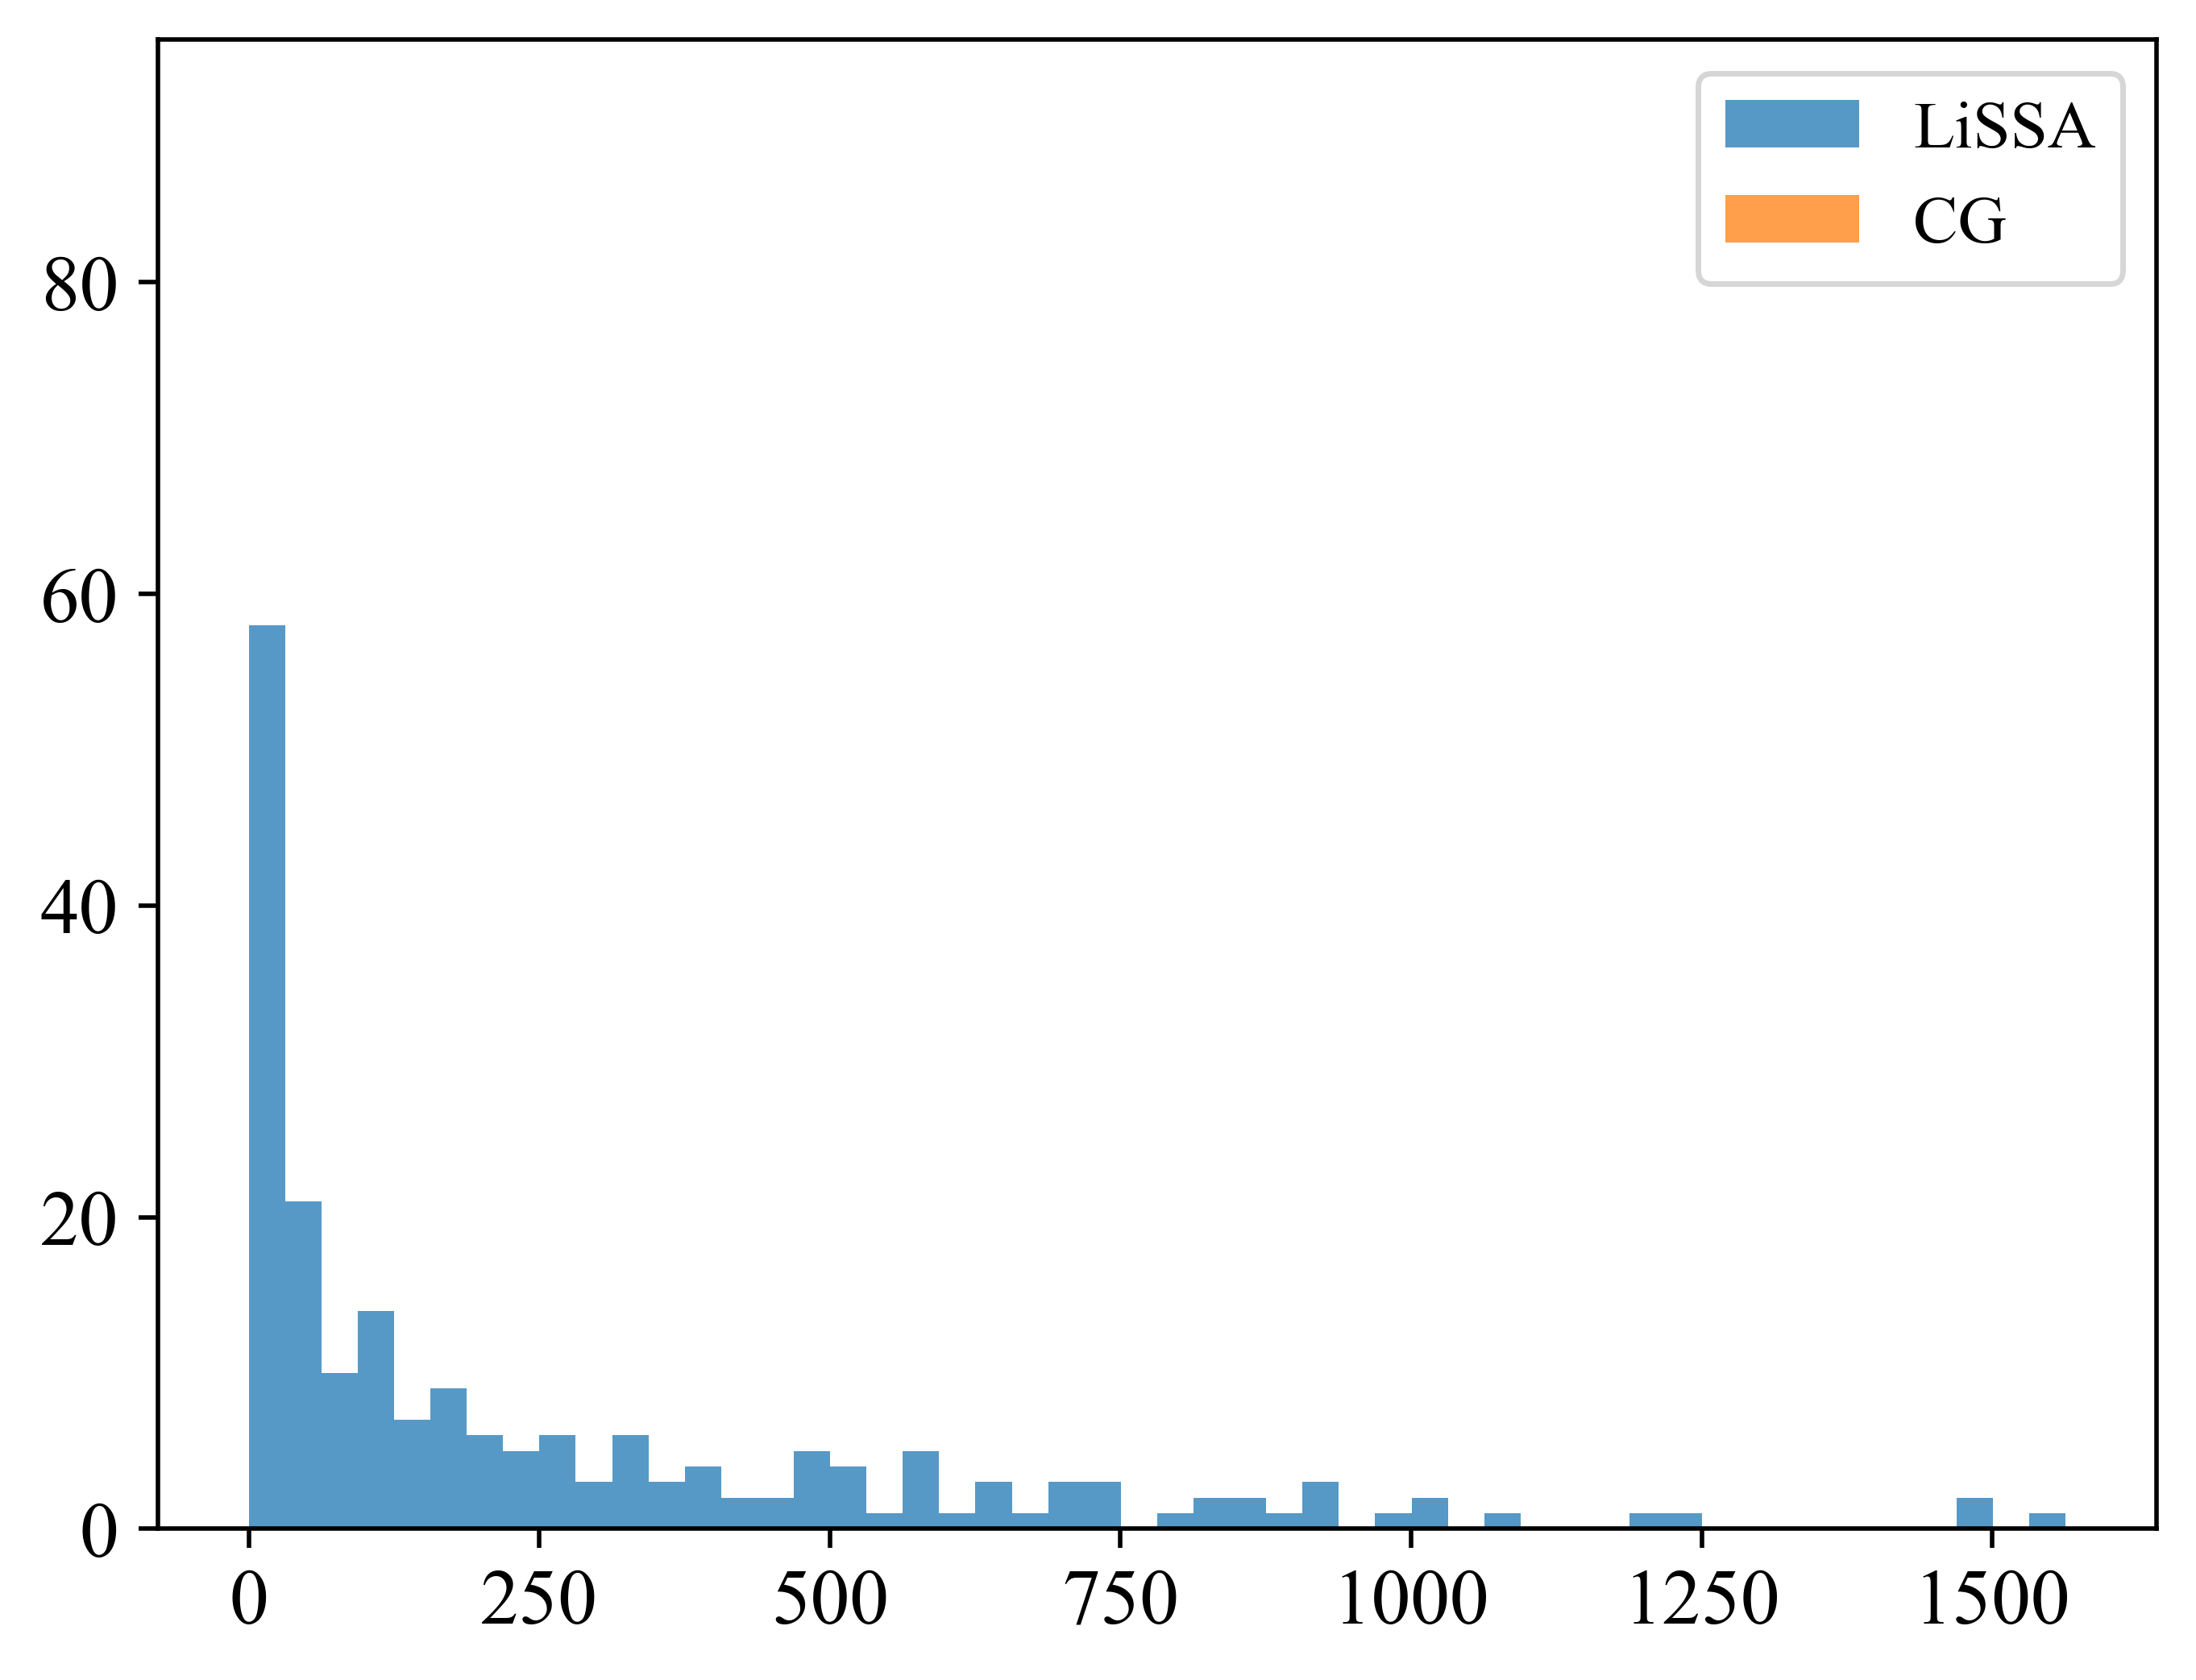

In [114]:
plt.hist(norms_li, label="LiSSA", bins=50, alpha=0.75)
plt.hist(norms_cg, label="CG", bins=50, alpha=0.75)
plt.legend()

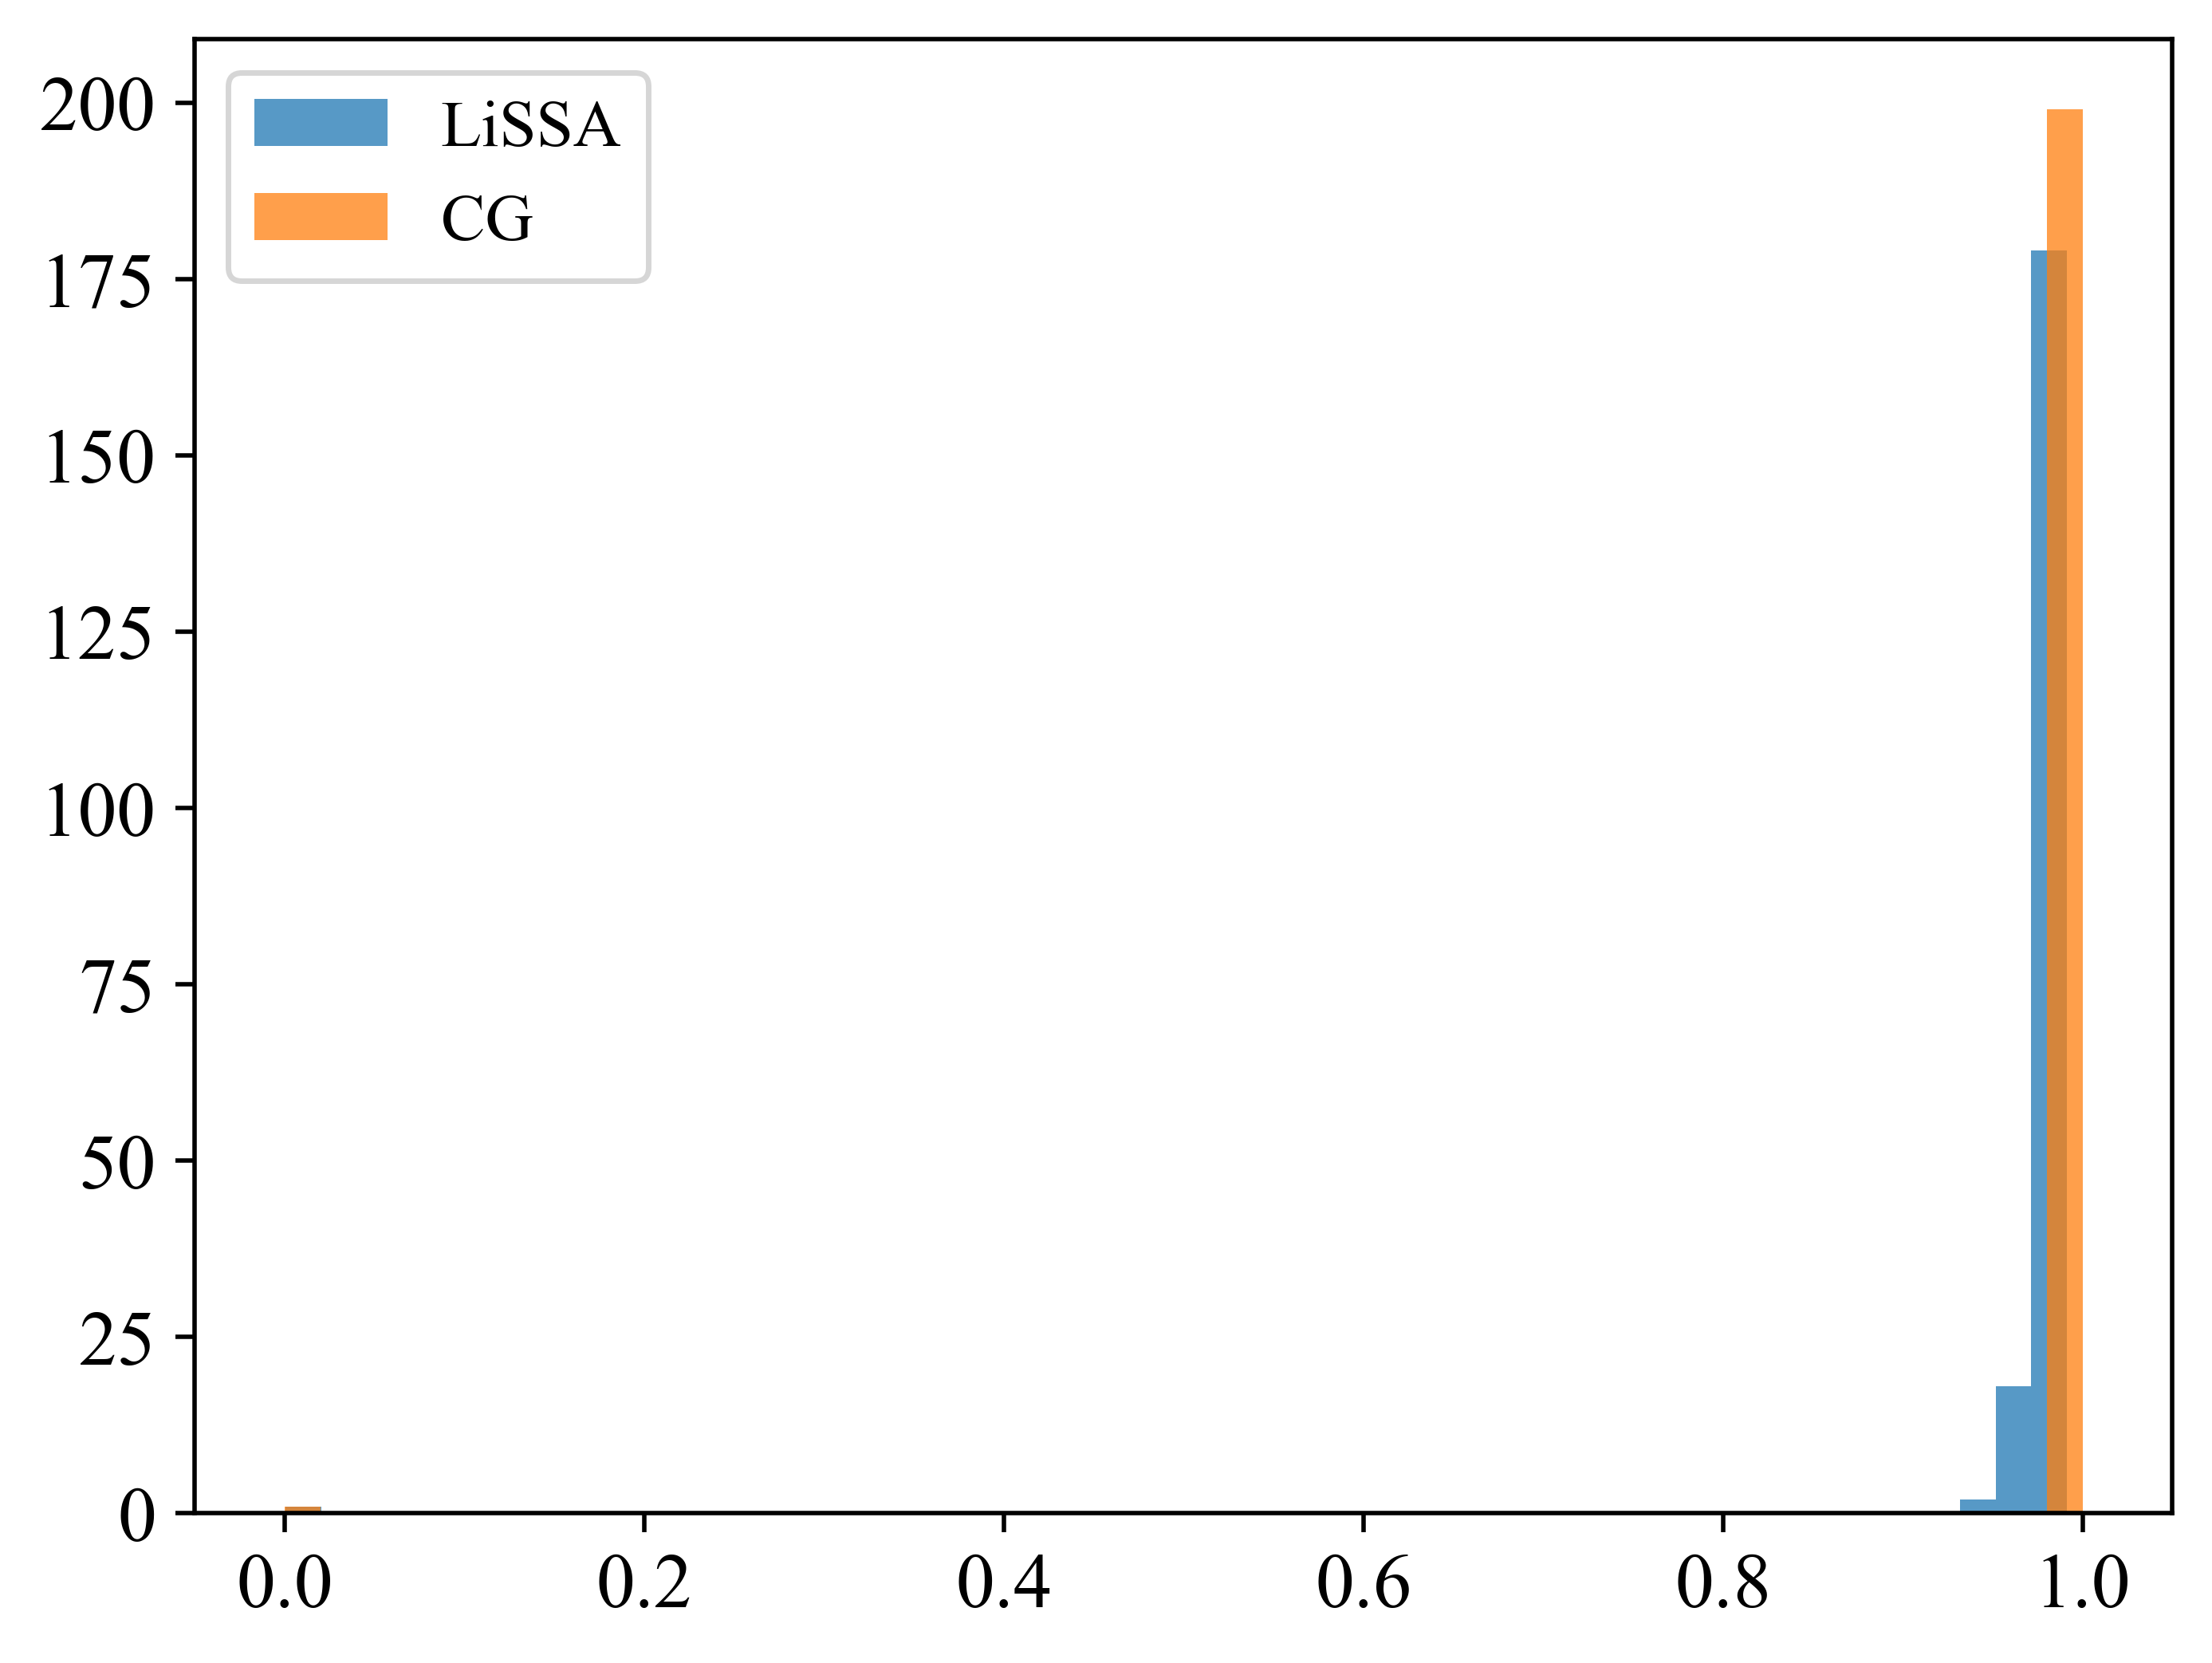

In [70]:
plt.hist(dirs_li, label="LiSSA", bins=50, alpha=0.75)
plt.hist(dirs_cg, label="CG", bins=50, alpha=0.75)
plt.legend()